# Data Cleaning and Pre-Processing

Data quality is of paramount importance to analysis. I look into the datasets provided to check for inconsistencies in data types, range, and fill missing values/fix inaccuracies to the best of my knowlege, referencing across datasets and columns for information. 

Keeping overarching intention of customer and product segmentation in mind, I also identify features that could be useful for the analysis, leaving out irrelevant data.  

## Direct links to sections:

1. [User Data](#User-Data)
2. [Delivery Info](#Delivery-Info)
3. [Order Details](#Order-Details)
4. [Menu](#Menu)
5. [Combined Dataset](#Combined-Dataset)

## Import Libraries

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def clean_date(df, col): 
    df[col+'_year'] = pd.DatetimeIndex(df[col]).year #create new column for year
    df[col+'_month'] = pd.DatetimeIndex(df[col]).month #create new column for month
    df[col+'_day'] = pd.DatetimeIndex(df[col]).day #create new column for day
    
    return df

def clean_postalcode_non_int(x):
    if isinstance(x, float):
        if len(str(int(x))) < 6:
            return str(str(int(x)).zfill(6))
        else:
            return str(x)
    elif isinstance(x, str):
        if len(x) < 6:
            return (x.zfill(6))
        else:
            return x
    else:
        return np.nan

def consolidate_platform(x):
    if x in ['mobile-ios','mobile-android','iOS']:
        return 'mobile'
    elif x in ['web','web-group','web-group-teams']:
        return 'web'
    elif x == 'sales':
        return 'sales'
    else:
        return 'legacy'

def set_region(x):
    i = str(x)[:2]
    if i in ['01', '02', '03', '04', '05', '06']:
        return 1
    elif i in ['07', '08']:
        return 2
    elif i in ['14', '15', '16']:
        return 3
    elif i in ['09', '10']:
        return 4
    elif i in ['11', '12', '13']:
        return 5
    elif i in ['17']:
        return 6
    elif i in ['18', '19']:
        return 7
    elif i in ['20', '21']:
        return 8
    elif i in ['22', '23']:
        return 9
    elif i in ['24', '25', '26', '27']:
        return 10
    elif i in ['28', '29', '30']:
        return 11
    elif i in ['31', '32', '33']:
        return 12
    elif i in ['34', '35', '36', '37']:
        return 13
    elif i in ['38', '39', '40', '41']:
        return 14
    elif i in ['42', '43', '44', '45']:
        return 15
    elif i in ['46', '47', '48']:
        return 16
    elif i in ['49', '50', '81']:
        return 17
    elif i in ['51', '52']:
        return 18
    elif i in ['53', '54', '55', '82']:
        return 19
    elif i in ['56', '57']:
        return 20
    elif i in ['58', '59']:
        return 21
    elif i in ['60', '61', '62', '63', '64']:
        return 22
    elif i in ['65', '66', '67', '68']:
        return 23
    elif i in ['69', '70', '71']:
        return 24
    elif i in ['72', '73']:
        return 25
    elif i in ['77', '78']:
        return 25
    elif i in ['75', '76']:
        return 27
    elif i in ['79', '80']:
        return 28
    else:
        return np.nan 

## User Data

In [3]:
#Import data
users = pd.read_csv('../raw/users.csv')

In [4]:
# #Inspect data
# users.sample()

In [5]:
#Define original dataset shape
initial_nrows = users.shape[0]
initial_cols = users.shape[1]

In [6]:
#Print number of unique users and features
print('User data includes {} user_ids out of which {} are unique.'.format(initial_nrows,users.id.nunique())+'\n'+'\n'+'-'*75)
print('\n'+'There are {} features including:'.format(initial_cols))

list(users.columns)

User data includes 60301 user_ids out of which 60301 are unique.

---------------------------------------------------------------------------

There are 17 features including:


['id',
 'address',
 'postal_code',
 'created_at',
 'updated_at',
 'roles',
 'zone_id',
 'location_id',
 'account_balance',
 'card_brand',
 'notes',
 'coupon_code',
 'floor',
 'unit_no',
 'blk_tower',
 'company_name',
 'birthday']

### Missing data

In [7]:
#Check for missing values
print('Columns with missing data are sorted starting from the column with most missing values:')

#Find % of missing values in each column
missing_pct = pd.DataFrame(users.isnull().sum()/users.shape[0], columns=['%Null']).sort_values('%Null',ascending=False)

#Print only those with missing values
missing_pct[missing_pct['%Null']> 0]


Columns with missing data are sorted starting from the column with most missing values:


,%Null
notes,0.999204
zone_id,0.852308
birthday,0.829588
coupon_code,0.781629
roles,0.711812
card_brand,0.699922
blk_tower,0.639077
company_name,0.622494
unit_no,0.071591
floor,0.066384


### Useful features

Taking into consideration the amount of missing values in some columns, I identify the following columns to be potentially useful for profiling users and prioritise data cleaning accordingly:


`account_balance`, `card_brand`, `coupon_code`, `birthday`

In [8]:
#Identify useful features for customer profiling 
profile_features = ['id','account_balance','card_brand','coupon_code','birthday']

In [9]:
#Inspect data types
users[profile_features].dtypes

id                  int64
account_balance     int64
card_brand         object
coupon_code        object
birthday           object
dtype: object

I convert `birthday` values into to datetime type.

In [10]:
users.birthday = pd.to_datetime(users.birthday)

I proceed to check for missing values.

In [11]:
#Inspect missing data
users[profile_features].isnull().sum()

id                     0
account_balance        0
card_brand         42206
coupon_code        47133
birthday           50025
dtype: int64

For `birthday`, I create a new column to compute age using year of birth.

In [12]:
#Compute age using year of birth
users['age'] = datetime.datetime.now().year - users.birthday.dt.year

I check where age is negative and impute as null since age cannot be negative.

I also create new columns for birth year, month and day, and compute year as null where year is beyond current year.

In [13]:
#Check for negative values
print('\n'+'There are {} rows with negative age values.'.format(users[users.age < 0].shape[0]))


There are 334 rows with negative age values.


In [14]:
#Correct negative age values as null
users.loc[users.age < 0, 'age'] = np.nan

In [15]:
#Create new columns for year, month and day
users = clean_date(
    users, 
    'birthday'
)

#Correct birthday_year values where > current year
users.loc[users.birthday_year > datetime.datetime.now().year, 'birthday_year'] = np.nan

I add the new columns `birthday_year`,`birthday_month`, `age` to profile features in replacement of `birthday`.

In [16]:
#Add new columns, drop birthday
profile_features = [
    'id',
    'account_balance',
    'card_brand',
    'coupon_code',
    'birthday_year', 
    'birthday_month',
    'age'
]

I also convert `coupon_code` to binary, 1 meaning that the user used a coupon code upon registering an account. 

In [17]:
#First fill null values in coupon code column with 0
users.coupon_code.fillna(0, inplace=True)

In [18]:
#Then convert coupon_code to binary in new column
users['has_coupon'] = users.coupon_code.map(lambda x : 1 if x !=0 else 0)

#Check class representation
users.has_coupon.value_counts(dropna=False)

0    47133
1    13168
Name: has_coupon, dtype: int64

I add the new column `has_coupon` to profile features in replacement of `coupon_code`.

In [19]:
#Add new columns, drop birthday
profile_features = [
    'id',
    'account_balance',
    'card_brand',
    'has_coupon',
    'birthday_year', 
    'birthday_month',
    'age'
]

In [20]:
#Inspect missing data
users[profile_features].isnull().sum()

id                     0
account_balance        0
card_brand         42206
has_coupon             0
birthday_year      50359
birthday_month     50025
age                50359
dtype: int64

I leave the rest of the null values as is for now. 

## Delivery Info

In [21]:
#Import data
delivery = pd.read_csv('../raw/delivery_orders.csv')

In [22]:
# #Inspect data
# delivery.sample()

In [23]:
#Check missing values for location_id which is the key to be used to merge postal code information
delivery.location_id.isnull().sum()

3

Retrieve and merge postal code data for delivery locations.

In [24]:
#Import location data for postal code
loc = pd.read_csv('../raw/locations.csv')

In [25]:
#Take only id and postal code from locations.csv
loc = loc[['id','postal_code']]

In [26]:
#Merge postal_code information
delivery_with_postal_code = pd.merge(delivery, loc, how='left',left_on = 'location_id', right_on='id', suffixes=('','_loc')).drop('id_loc',axis=1)

In [27]:
#Define original dataset shape
initial_nrows = delivery_with_postal_code.shape[0]
initial_cols = delivery_with_postal_code.shape[1]

In [28]:
#Print number of unique users and features
print('Delivery with postal code data includes {} delivery orders from {} unique users.'.format(initial_nrows,delivery_with_postal_code.user_id.nunique())+'\n'+'\n'+'-'*75)
print('\n'+'There are {} features including:'.format(initial_cols))

list(delivery_with_postal_code.columns)

Delivery with postal code data includes 32915 delivery orders from 9468 unique users.

---------------------------------------------------------------------------

There are 72 features including:


['id',
 'zone_id',
 'address',
 'state',
 'item',
 'created_at',
 'updated_at',
 'location_id',
 'user_id',
 'cart_id',
 'amount',
 'charge_id',
 'discount',
 'due',
 'credit_deduction',
 'delivery_orders_count',
 'feedback_link',
 'meal_names',
 'order_id',
 'due_dates',
 'to_office',
 'card_details',
 'billing_reference',
 'credit_terms',
 'card_brand',
 'card_last4',
 'source',
 'macros',
 'component_string',
 'timing',
 'delivery_fee',
 'delivery_fees',
 'cbd_fee',
 'meal_wave',
 'version',
 'card_id',
 'islandwide',
 'pickup_point_id',
 'trello_url',
 'pickup_points',
 'floor',
 'unit_no',
 'delivery_node_id',
 'surcharge_amount',
 'business',
 'serving_date',
 'promo_code',
 'hub_id',
 'delivery_state',
 'type',
 'delivery_note',
 'courier',
 'sample',
 'feedback_form_id',
 'product_tracking_option_id',
 'business_unit_tracking_option_id',
 'invoice_date',
 'xero_contact_id',
 'gst_charged',
 'salesperson_id',
 'delivery_fee_excluding_gst',
 'surcharge_amount_excluding_gst',
 'di

<b> I keep only rows with `user_id` matching `id` in users dataset because this means we have the user data. 

In [29]:
#Filter for users we know
delivery_info = delivery_with_postal_code[delivery_with_postal_code['user_id'].isin(users.id)]

In [30]:
#Print number of unique users for which we have delivery info
print('\n'+'We now have data for {} delivery orders from {} unique users.'.format(delivery_info.shape[0],delivery_info.user_id.nunique()))


We now have data for 32845 delivery orders from 9425 unique users.


In [31]:
#Print time period of data
print('\n'+'Delivery info data we have is from {} to {}'.format(pd.to_datetime(delivery_info.serving_date).min(),pd.to_datetime(delivery_info.serving_date).max()))


Delivery info data we have is from 2014-07-07 03:17:28.448908 to 2019-04-16 11:00:00


### Missing data

In [32]:
#Check for missing values
print('Columns with missing data are sorted starting from the column with most missing values:')

#Find % of missing values in each column
missing_pct = pd.DataFrame(delivery_info.isnull().sum()/delivery_info.shape[0], columns=['%Null']).sort_values('%Null',ascending=False)

#Print only those with missing values
missing_pct[missing_pct['%Null']> 0]

Columns with missing data are sorted starting from the column with most missing values:


,%Null
pickup_points,1.000000
delivery_orders_count,1.000000
billing_reference,0.999970
trello_url,0.999208
islandwide,0.996955
due,0.995007
business,0.986786
cbd_fee,0.981580
xero_contact_id,0.976283
invoice_date,0.973542


### Useful Features

Taking into consideration the amount of missing values in some columns, I identify the following columns to be useful for profiling users and prioritise data cleaning accordingly:


`salesperson_id`,`zone_id`, `address`, `discount`, `due_dates`, `card_details`, `card_brand`, `source`, `delivery_fee`, `meal_wave`, `surcharge_amount`, `promo_code`, `feedback_form_id`, `postal_code`

In [33]:
#Identify useful columns  
profile_features_del = ['id','user_id','salesperson_id','zone_id','address','discount', 'due_dates', 
                        'card_details', 'card_brand', 'source', 'delivery_fee', 
                        'meal_wave', 'surcharge_amount', 'promo_code', 'feedback_form_id','postal_code']

In [34]:
#Inspect data types
delivery_info[profile_features_del].dtypes

id                    int64
user_id               int64
salesperson_id      float64
zone_id             float64
address              object
discount            float64
due_dates            object
card_details         object
card_brand           object
source               object
delivery_fee        float64
meal_wave            object
surcharge_amount    float64
promo_code           object
feedback_form_id     object
postal_code          object
dtype: object

Since `postal_code` should not be object type. I investigate this.

In [35]:
#Find error in postal_code
try:
    delivery_info.postal_code.dropna().astype(float) 
except Exception as ex:
    print('Error found: {}'.format(ex))

Error found: could not convert string to float: 'T312'


The error reveals that there are string type values in the column. I manually check the column for 'T312' and replace with the correct value i.e. '465403' from desktop research on valid postal code.

In [36]:
#Replace postal_code T312 with valid postal code  
delivery_info.replace('T312', '465403', inplace=True)

I convert `due_dates` to datetime together with the other dates in the dataset; `created_at`,`serving_date`,`invoice_date`

In [37]:
dates= ['created_at','due_dates','serving_date','invoice_date']

In [38]:
#Convert to datetime
for i in dates:
    try:
        delivery_info[i] = pd.to_datetime(delivery_info[i])
    except Exception as e:
        print('Error on {} column.'.format(i))
        print('Error messsage: {}'.format(e))

Error on due_dates column.
Error messsage: ('Unknown string format:', "---\n'2015-11-19': 11:15am\n")


Some cleaning needs to be done on the values in `due_dates` before it can be converted.
<p>
I also create two new columns to split due date time and dates.

In [39]:
#To strip out date and convert to datetime 
delivery_info['due_dates_only'] = pd.to_datetime(
    delivery_info.due_dates.map(
        lambda x : x.split('\n')[1].split(': ')[0]
    )
)

#Checks new column type
delivery_info.due_dates_only.dtype

dtype('<M8[ns]')

In [40]:
#Strip out time -note default date is added.
delivery_info['due_dates_time'] = pd.to_datetime(
    delivery_info.due_dates.map(
        lambda x : ":".join([
            x.split('\n')[1].split(':')[1].replace(' " ',"").replace(' ',""),
            x.split('\n')[1].split(':')[2].replace('"',"")
        ])
    )
)

#Checks new column type
delivery_info.due_dates_time.dtype

dtype('<M8[ns]')

I would  assume that `due_dates` has the same values as those in `serving_date` given that the meal is served when its due. I check if this is true.

In [41]:
print('\n'+'There are {} rows where due date and serving date did not coincide (meal served days earlier or later).'
      .format(
          delivery_info[delivery_info.due_dates_only.dt.date != delivery_info.serving_date.dt.date].shape[0]
      )+'\n'+'-'*100
     )

print('There are {} rows where due time and serving time did not coincide (meal served at earlier or later time).'
      .format(
          delivery_info[delivery_info.due_dates_only.dt.time != delivery_info.serving_date.dt.time].shape[0]
      )
     )


There are 47 rows where due date and serving date did not coincide (meal served days earlier or later).
----------------------------------------------------------------------------------------------------
There are 32696 rows where due time and serving time did not coincide (meal served at earlier or later time).


Most of the time, the order is served on the day the customer requires it (not withstanding time inaccuracies). However, there are 48 instances where this is not so. We can investigate this later on.

I add `due_dates_only` to profile features in place of `due_dates`.

In [42]:
#Add due_dates_only in place of due_dates
profile_features_del = ['id','user_id','zone_id','salesperson_id', 'address', 'discount', 'due_dates_only', 
                        'card_details', 'card_brand', 'source', 'delivery_fee', 
                        'meal_wave', 'surcharge_amount', 'promo_code', 'feedback_form_id','postal_code']

I proceed to check for missing values.

In [43]:
#Check for missing values
print('Columns with missing data are sorted starting from the column with most missing values:')

#Find % of missing values in each column
missing_pct = pd.DataFrame(delivery_info[profile_features_del].isnull().sum()/delivery_info.shape[0], columns=['%Null']).sort_values('%Null',ascending=False)

#Print only those with missing values
missing_pct[missing_pct['%Null']> 0]

Columns with missing data are sorted starting from the column with most missing values:


,%Null
meal_wave,0.935089
salesperson_id,0.931984
promo_code,0.912650
feedback_form_id,0.859370
card_details,0.475384
surcharge_amount,0.369006
delivery_fee,0.325285
card_brand,0.305008
source,0.265246
discount,0.158198


For `meal_wave`, I first check the class representation.

In [44]:
#Check class representation
delivery_info.meal_wave.value_counts()

third     845
second    665
first     621
1           1
Name: meal_wave, dtype: int64

There are broadly three categories and a single outlier labelled '1'. I investigate this.

In [45]:
#Check time served for specific row
delivery_info[delivery_info.meal_wave == '1'].serving_date

6801   2014-07-07 03:17:28.448908
Name: serving_date, dtype: datetime64[ns]

The order was served at 3am in the morning and not likely to belong to any of the three main categories in `meal_wave`. I replace this with 0.

In [46]:
#Replace the error
delivery_info.meal_wave.replace('1',0 , inplace=True)

I plot the timings during which meals are served, to look for peak periods.

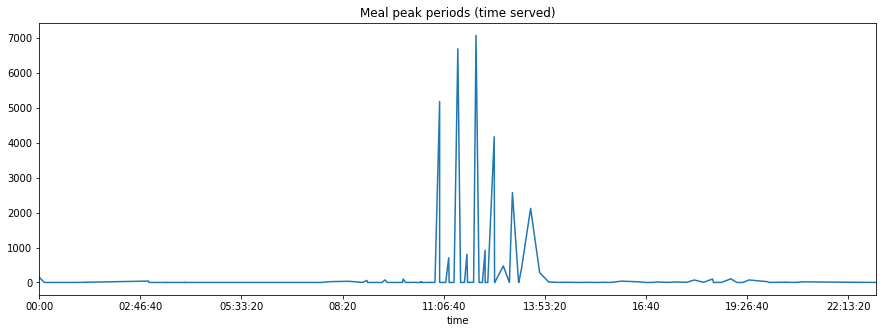

In [47]:
#Plot number of meals against time
plt.figure(figsize=(15,5))
x = delivery_info.serving_date.dt.time.value_counts().sort_index()
x.plot(kind='line',title='Meal peak periods (time served)')
plt.show()

It is clear that the lunch meal occasion i.e. 11am-130pm is the restaurant's key service. We can also see some activity between 6-8pm when the restaurant is open to B2C customers but this is not significant. 

I also look at the labelled data to see what the wave timing definitions are.

Meal Wave = First
--------------------------------------------------
11:00:00    120
11:15:00    185
11:30:00    142
11:45:00    149
12:00:00     24
12:30:00      1
Name: serving_date, dtype: int64


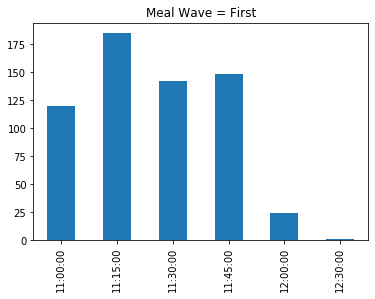

First wave peaks at 11:15am. Busy period is between 11:15-1145am. It will make sense to define first wave as 11:00 to 11:59am.


Meal Wave = Second
--------------------------------------------------
12:00:00    173
12:15:00    230
12:30:00     99
12:45:00    146
13:00:00     17
Name: serving_date, dtype: int64


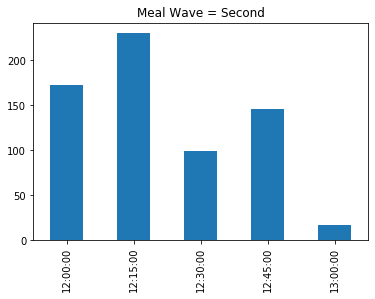

Second wave peaks at 12:15am. Busy period is between 12:00-12:15am. It will make sense to define second wave as 12:00 to 12:59am.


Meal Wave = Third
--------------------------------------------------
11:00:00     41
11:15:00     29
11:30:00     45
11:45:00     60
12:00:00     56
12:15:00     64
12:30:00     46
12:45:00     32
13:00:00    117
13:15:00    166
13:30:00     99
13:45:00     90
Name: serving_date, dtype: int64


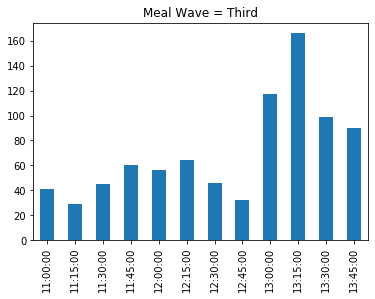

Third wave peaks at 13:15am. Busy period is between 13:00-1315am. It will make sense to define third wave as 13:00 to 13:59am.


In [48]:
#Plot first wave peak periods
print('Meal Wave = First'+'\n'+'-'*50)
print(delivery_info[delivery_info.meal_wave == 'first'].serving_date.dt.time.value_counts().sort_index())
delivery_info[delivery_info.meal_wave == 'first'].serving_date.dt.time.value_counts().sort_index().plot(kind='bar',title='Meal Wave = First')
plt.show()
print('First wave peaks at 11:15am. Busy period is between 11:15-1145am. It will make sense to define first wave as 11:00 to 11:59am.')


#Plot second wave peak periods
print('\n'+'\n'+'Meal Wave = Second'+'\n'+'-'*50)
print(delivery_info[delivery_info.meal_wave == 'second'].serving_date.dt.time.value_counts().sort_index())
delivery_info[delivery_info.meal_wave == 'second'].serving_date.dt.time.value_counts().sort_index().plot(kind='bar',title='Meal Wave = Second')
plt.show()
print('Second wave peaks at 12:15am. Busy period is between 12:00-12:15am. It will make sense to define second wave as 12:00 to 12:59am.')

#Plot third wave peak periods
print('\n'+'\n'+'Meal Wave = Third'+'\n'+'-'*50)
print(delivery_info[delivery_info.meal_wave == 'third'].serving_date.dt.time.value_counts().sort_index())
delivery_info[delivery_info.meal_wave == 'third'].serving_date.dt.time.value_counts().sort_index().plot(kind='bar',title='Meal Wave = Third')
plt.show()
print('Third wave peaks at 13:15am. Busy period is between 13:00-1315am. It will make sense to define third wave as 13:00 to 13:59am.')


I revise `meal_wave` values for each row according to the above timing defintions for each wave and indicate the other timings as '0'.

In [49]:
import datetime
delivery_info.loc[
    (delivery_info.serving_date.dt.time > datetime.time(12,59))&
    (delivery_info.serving_date.dt.time < datetime.time(14,00)),
    'meal_wave'
] = 'third'

delivery_info.loc[
    (delivery_info.serving_date.dt.time > datetime.time(11,59))&
    (delivery_info.serving_date.dt.time < datetime.time(13,00)),
    'meal_wave'
] = 'second'

delivery_info.loc[
    (delivery_info.serving_date.dt.time > datetime.time(10,59))&
    (delivery_info.serving_date.dt.time < datetime.time(12,00)),
    'meal_wave'
] = 'first'

In [50]:
delivery_info.meal_wave.fillna(0, inplace=True)

In [51]:
#Check class representation
delivery_info.meal_wave.value_counts(dropna=False)

first     13430
second    12665
third      5385
0          1365
Name: meal_wave, dtype: int64

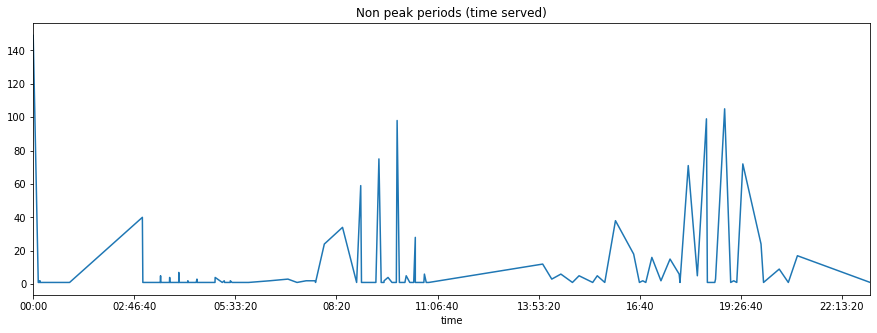

In [52]:
#Plot other meal delivery timings
plt.figure(figsize=(15,5))
delivery_info[delivery_info.meal_wave == 0].serving_date.dt.time.value_counts().sort_index().plot(title='Non peak periods (time served)')
plt.show()

From the above plot, it is interesting to see some activity in three main periods, 12-3am, 8-1030am and 4-730pm.

For `promo_code`, I convert values to binary, 1 being that a promo code was used.

In [53]:
# #Inspect first 5 rows of class representation
# pd.DataFrame(delivery_info.promo_code.value_counts()).head()

In [54]:
#Compute missing values as 0
delivery_info.promo_code.fillna(0,inplace=True)

#Convert non null values as 1
delivery_info['promo_code_used'] = delivery_info.promo_code.map(lambda x : 1 if x!=0 else 0)

In [55]:
#Check class representation
delivery_info.promo_code_used.value_counts()

0    29976
1     2869
Name: promo_code_used, dtype: int64

I also look at all the feedback related columns together and investigate relationship.

In [56]:
#Find columns with 'feedback' in header
fb = delivery_info.columns[delivery_info.columns.str.contains('feedback')]

print('\n'+'There are three columns related to feedback:')
list(fb.values)


There are three columns related to feedback:


['feedback_link', 'feedback_form_id', 'feedback_token']

In [57]:
#Check number of missing values in each column
delivery_info[fb].isnull().sum()

feedback_link       15304
feedback_form_id    28226
feedback_token      19491
dtype: int64

In [58]:
#Check relationship between the columns
print('Num missing values given feedback_token:')
print(delivery_info[delivery_info.feedback_token.notnull()][['feedback_form_id', 'feedback_link']].isnull().sum())

print('\n'+'Num missing values given feedback_form_id:')
print(delivery_info[delivery_info.feedback_form_id.notnull()][['feedback_token', 'feedback_link']].isnull().sum())

print('\n'+'Num missing values given feedback_link:')
print(delivery_info[delivery_info.feedback_link.notnull()][['feedback_token', 'feedback_form_id']].isnull().sum())

Num missing values given feedback_token:
feedback_form_id    13162
feedback_link       12560
dtype: int64

Num missing values given feedback_form_id:
feedback_token    4427
feedback_link        0
dtype: int64

Num missing values given feedback_link:
feedback_token      16747
feedback_form_id    12922
dtype: int64


I make a guess that while the option to provide feedback is given to customers as indicated by `feedback_link`, not all participate. For those who participate, we have the `feedback_form_id` for reference. Hence I decide to convert the latter to binary where presence of a value means user provided feedback i.e. 1, to keep information that the user provided feedback. 

In [59]:
#Compute missing values as '0'
delivery_info.feedback_form_id.fillna(0, inplace=True)

#Convert to binary
delivery_info['gave_feedback'] = delivery_info.feedback_form_id.map(lambda x : 1 if x!=0 else 0)

In [60]:
#Check class representation
delivery_info['gave_feedback'].value_counts()

0    28226
1     4619
Name: gave_feedback, dtype: int64

I add the new columns to profile features in replacement of `feedback_form_id` and `promo_code`.

In [61]:
#Add new columns 
profile_features_del = ['id','user_id','zone_id', 'salesperson_id','address','discount', 'due_dates_only', 
                        'card_details', 'card_brand', 'source', 'delivery_fee', 
                        'meal_wave', 'surcharge_amount', 'promo_code_used', 'gave_feedback','postal_code']

I look at all the surcharge related columns together and investigate relationship.

In [62]:
#Find columns with 'surcharge' in header
surcharge = delivery_info.columns[delivery_info.columns.str.contains('surcharge')]

print('There are two columns related to surcharge:')
list(surcharge.values)

There are two columns related to surcharge:


['surcharge_amount', 'surcharge_amount_excluding_gst']

In [63]:
#Check number of missing values in each column
delivery_info[surcharge].isnull().sum()

surcharge_amount                  12120
surcharge_amount_excluding_gst        0
dtype: int64

In [64]:
#Find surcharge_amount_excluding_gst values, where surcharge amount is missing
delivery_info.loc[delivery_info.surcharge_amount.isnull(),'surcharge_amount_excluding_gst'].value_counts()

0    12120
Name: surcharge_amount_excluding_gst, dtype: int64

Where `surcharge_amount` is missing, `surcharge_amount_excluding_gst` is \$0. Hence i compute missing values as 0.

In [65]:
#Compute missing values as '0'
delivery_info.surcharge_amount.fillna(0, inplace=True)

For delivery fees, I look at three columns to see if I can find any information to help me compute missing values: <br>`delivery_fees`, `delivery_fee`, `delivery_fee_excluding_gst`

In [66]:
delivery_cost = ['delivery_fee','delivery_fees','delivery_fee_excluding_gst']

In [67]:
#Checks missing values 
delivery_info[delivery_cost].isnull().sum()

delivery_fee                  10684
delivery_fees                 31698
delivery_fee_excluding_gst        0
dtype: int64

Note that `delivery_fee_excluding_gst` has no missing values. I take a closer look where delivery_fee_excluding_gst is 0. Given this information, `delivery_fee` and `delivery_fees` should be 0 as well. I check if so. 

Where the `delivery_fee_excluding_gst` is 0, are there any values in `delivery_fee` and `delivery_fees` other than 0 (or missing). If no, I can proceed to assume missing values as 0. 

In [68]:
#Find rows where delivery_fee_excluding_gst is 0
supposed_zero = delivery_info[delivery_info.delivery_fee_excluding_gst == 0][delivery_cost]

In [69]:
#Find values in delivery_fee where delivery_fee_excluding_gst is 0
supposed_zero.delivery_fee.value_counts()

0.0       8862
2000.0      98
Name: delivery_fee, dtype: int64

Where `delivery_fee_excluding_gst` is supposedly \$0, there are actually 98 rows where `delivery_fee` is \$20. I check the corresponding values in `delivery_fees` where `delivery_fee` is \$20.

In [70]:
#Find rows where delivery_fee is 2000 and delivery_fees is not null 
supposed_zero[(supposed_zero.delivery_fee == 2000) & (supposed_zero.delivery_fees.notnull())]

,delivery_fee,delivery_fees,delivery_fee_excluding_gst
7814,2000.0,---\n'2016-12-15': 2000\n,0
7827,2000.0,---\n'2016-12-23': 2000\n,0
7828,2000.0,---\n'2016-12-23': 2000\n,0
7840,2000.0,---\n'2016-12-24': 2000\n,0
7847,2000.0,---\n'2016-12-28': 2000\n,0
7855,2000.0,---\n'2016-12-25': 2000\n,0
8098,2000.0,---\n'2016-12-23': 2000\n,0
8100,2000.0,---\n'2016-12-23': 2000\n,0
8101,2000.0,---\n'2016-12-24': 2000\n,0


The above shows that where `delivery_fee` is 2000, `delivery_fees` is also 2000. It is likely that `delivery_fees`, `delivery_fee` have the same information.

To investigate this, for rows where there is information in `delivery_fees`, I create new columns to split out the fee information.

In [71]:
#Find rows where delivery_fees is not null and not 'nan'
delvfees_notnull = delivery_info[(delivery_info.delivery_fees != 'nan')&(delivery_info.delivery_fees.notnull())]

#Split dates into new column
delivery_info['delivery_fees_date'] = pd.to_datetime(
    delvfees_notnull.delivery_fees.map(
        lambda x : x.split("'")[1]
    )
)

#Split fee into new column
delivery_info['delivery_fees_amt'] = delvfees_notnull.delivery_fees.map(
    lambda x : x.split("': ")[1].replace('\n','').replace("'",'')
)


print('{} rows have fee date values.'.format(delivery_info[delivery_info.delivery_fees_date.notnull()].shape[0]))
print('{} rows have fee amount values.'.format(delivery_info[delivery_info.delivery_fees_amt.notnull()].shape[0]))

1147 rows have fee date values.
1147 rows have fee amount values.


I check if the fee amounts tally.

In [72]:
#Find rows where there is information in delivery_fee and delivery_fees_amt
df = delivery_info[
    (delivery_info.delivery_fee.notnull())&
    (delivery_info.delivery_fees_amt.notnull())
][['delivery_fees_amt','delivery_fee']]

#Check for difference in fee amounts
df[df.delivery_fee.apply(lambda x: str(x).split('.')[0]) != df.delivery_fees_amt]

,delivery_fees_amt,delivery_fee
4457,0,5500.0
7440,6000,0.0


There are two rows where the information differs. Hence it cannot be assumed that the rows provide exactly the same information. 

I proceed to impute missing values in `delivery_fee` as 0 and will just use this column only.

In [73]:
#Compute missing values as '0'
delivery_info.delivery_fee.fillna(0, inplace=True)

For `source`, I consolidate orders made on the same platform e.g. web/ mobile/sales and group the rest as one category, assumed to be so due to legacy (as adviced by the restaurant).

In [74]:
#Check unique values
delivery_info.source.unique()

array([nan, 'personalised', 'sales', 'mobile-android', 'iOS',
       'mobile-ios', 'web', 'christmas_special', 'web-group',
       'web-group-teams'], dtype=object)

In [75]:
#Consolidating categories
delivery_info.source = delivery_info.source.apply(lambda x : consolidate_platform(x))

#Print new categories
delivery_info.source.value_counts()

legacy    11535
mobile    10358
web        8635
sales      2317
Name: source, dtype: int64

For `discount` , I impute missing values as '0'.

In [76]:
#Check class representation
delivery_info.discount.value_counts().head()

0.0       24562
200.0      1179
600.0       510
500.0       415
1000.0      284
Name: discount, dtype: int64

In [77]:
#Compute missing values as '0'
delivery_info.discount.fillna(0,inplace=True)

I look at address for information to compute missing values in `zone_id`.

In [78]:
#Find address values where zone_id is missing
print('Where zone_id is null, addresses are:'+'\n'+'-'*60)
print(delivery_info.loc[delivery_info.zone_id.isnull(),'address'])

#Find mode of zone_id where address == 'Roundabout between MBFC Tower 1 and Tower 2'
most_likely_zone_id = delivery_info[
    delivery_info.address == 'Roundabout between MBFC Tower 1 and Tower 2'
].zone_id.mode()[0]

print('\n'+'I find that the most likely zone_id value where address is "Roundabout between MBFC Tower1 and Tower 2" is {}.'.format(most_likely_zone_id))

Where zone_id is null, addresses are:
------------------------------------------------------------
11421                                            NaN
31969    Roundabout between MBFC Tower 1 and Tower 2
Name: address, dtype: object

I find that the most likely zone_id value where address is "Roundabout between MBFC Tower1 and Tower 2" is 74.0.


I compute the missing value for "Roundabout between MBFC Tower1 and Tower 2" as 74.0, and fill missing values as '0'.

In [79]:
#Replace the missing values in zone_id where address == 'Roundabout between MBFC Tower1 and Tower 2' to 74.0
delivery_info.loc[
    (delivery_info.address == 'Roundabout between MBFC Tower 1 and Tower 2')&
    (delivery_info.zone_id.isnull()),
    'zone_id'
] = most_likely_zone_id

In [80]:
#Compute missing values as '0'
delivery_info.zone_id.fillna(0, inplace=True)

For `postal_code`, I fill missing values as 000000 and convert values to float type.

In [81]:
#Compute missing values as '0'
delivery_info.postal_code.fillna(0, inplace=True)

In [82]:
#Convert to float type
delivery_info.postal_code = delivery_info.postal_code.astype(float)

I then group postal codes into regions according to URA's district definition.

In [83]:
#First we need to add missing zeros where postal code starts with 0 e.g. 018394
delivery_info['postal_code_clean'] = delivery_info.postal_code.map(lambda x: clean_postalcode_non_int(x))

In [84]:
#Then group into regions
delivery_info['district'] = delivery_info.postal_code_clean.map(lambda x : set_region(x))

In [85]:
#Check if there are any postal codes not belonging to any district
delivery_info[delivery_info.district.isnull()]['postal_code_clean'].value_counts()

000000    12
Name: postal_code_clean, dtype: int64

I look at address for information to compute missing values in `district`.

In [86]:
#Find address values where zone_id is missing
print('Where district is null, addresses are:'+'\n'+'-'*60)
print(delivery_info.loc[delivery_info.district.isnull(),'address'].value_counts())

Where district is null, addresses are:
------------------------------------------------------------
Roundabout between MBFC Tower 1 and Tower 2    4
21 Ocean Way                                   2
Special Location                               2
TESTTOWER                                      2
Marina Bay Testing Tower                       1
Name: address, dtype: int64


I fill in the most probable district value for addresses in "Roundabout between MBFC Tower 1 and Tower 2" and fill 4 for 21 Ocean Way (From desktop research, postal code: 098374).

In [87]:
#Find mode of district values for the above addresses
print('\n'+'Most likely district value where address is "Roundabout between MBFC Tower 1 and Tower 2" is {}.'.format(delivery_info[delivery_info.address == 'Roundabout between MBFC Tower 1 and Tower 2'].district.mode()[0]))


Most likely district value where address is "Roundabout between MBFC Tower 1 and Tower 2" is 1.0.


In [88]:
#Replace the missing values 
delivery_info.loc[
    (delivery_info.address == 'Roundabout between MBFC Tower 1 and Tower 2')&
    (delivery_info.district.isnull()),
    'district'
] = 1

delivery_info.loc[
    (delivery_info.address == '21 Ocean Way')&
    (delivery_info.district.isnull()),
    'district'
] = 4

I add the new column to profile features in replacement of `postal_code`.

In [89]:
#Convert salesperson_id to binary
delivery_info.salesperson_id.fillna(0, inplace=True)
delivery_info.salesperson_id = delivery_info.salesperson_id.apply(lambda x: 1 if x != 0 else 0)

In [90]:
#Add new columns 
profile_features_del = ['id','user_id', 'address','zone_id', 'salesperson_id','discount', 'due_dates_only', 
                        'card_details', 'card_brand', 'source', 'delivery_fee', 
                        'meal_wave', 'surcharge_amount', 'promo_code_used', 'gave_feedback','district']

In [91]:
#Check again for missing values
delivery_info[profile_features_del].isnull().sum()

id                      0
user_id                 0
address                66
zone_id                 0
salesperson_id          0
discount                0
due_dates_only          0
card_details        15614
card_brand          10018
source                  0
delivery_fee            0
meal_wave               0
surcharge_amount        0
promo_code_used         0
gave_feedback           0
district                6
dtype: int64

I leave the rest of the null values as is for now. 

<b> Other Notes <b>

While checking class representations in `delivery_fees_amt`, I find an outlier in the data point where value is 9502015-9-8 .

It happens that there are two fee amounts in this order.

## Order Details

In [92]:
#Import data
order_items = pd.read_csv('../raw/order_items.csv')

In [93]:
# #Inspect data
# order_items.sample()

In [94]:
#Define original dataset shape
initial_nrows = order_items.shape[0]
initial_cols = order_items.shape[1]

In [95]:
#Print number of orders, unique menu items and features
print('Order data includes information on {} orders for {} unique menu items.'.format(initial_nrows,order_items.item_id.nunique())+'\n'+'\n'+'-'*75)
print('\n'+'There are {} features including:'.format(initial_cols))

list(order_items.columns)

Order data includes information on 285260 orders for 511 unique menu items.

---------------------------------------------------------------------------

There are 16 features including:


['id',
 'item_id',
 'quantity',
 'unit_price',
 'name',
 'delivery_order_id',
 'created_at',
 'updated_at',
 'item_type',
 'meal_code',
 'serving_date',
 'order_id',
 'type',
 'unit_price_excluding_gst',
 'gst_value',
 'bundle_meal_id']

<b>I keep only rows with `delivery_order_id` matching `id` in delivery info dataset because this means we have the delivery information and user data.

In [96]:
##Filter for delivery orders we know
u_order = order_items[order_items['delivery_order_id'].isin(delivery_info.id)]

In [97]:
#Print number of unique delivery ids for which we have order details
print('\n'+'We now have {} data for {} unique delivery orders.'.format(u_order.shape[0],u_order.delivery_order_id.nunique()))


We now have 57461 data for 29504 unique delivery orders.


In [98]:
#Print number of rows where delivery order id is not found in delivery info data set.
print('\n'+'Note that {} rows had delivery order ids which were not recognised.'.format(order_items[~order_items['delivery_order_id'].isin(delivery_info.id)].shape[0]))


Note that 227799 rows had delivery order ids which were not recognised.


In [99]:
#Print time period of data
print('\n'+'Order details data we have is from {} to {}'.format(pd.to_datetime(order_items.serving_date).min(),pd.to_datetime(order_items.serving_date).max()))


Order details data we have is from 2014-07-23 04:52:40 to 2019-08-27 19:00:00


### Missing data

In [100]:
#Check for missing values
print('Columns with missing data are sorted starting from the column with most missing values:')

#Find % of missing values in each column
missing_pct = pd.DataFrame(u_order.isnull().sum()/u_order.shape[0], columns=['%Null']).sort_values('%Null',ascending=False)

#Print only those with missing values
missing_pct[missing_pct['%Null']> 0]

Columns with missing data are sorted starting from the column with most missing values:


,%Null
bundle_meal_id,0.999443
order_id,0.990829
unit_price_excluding_gst,0.004212
gst_value,0.004212
type,0.000661
unit_price,0.000348
meal_code,0.000157
name,0.000104
item_type,0.000104
item_id,0.000087


### Useful Features

Taking into consideration the amount of missing values in some columns, I identify the following columns to be useful for profiling users and prioritise data cleaning accordingly:


`quantity`, `unit_price`, `item_type`

In [101]:
#Identify useful deatures
profile_features_ord = ['delivery_order_id','item_id','item_type','quantity', 'unit_price']

In [102]:
#Inspect data types
u_order[profile_features_ord].dtypes

delivery_order_id      int64
item_id              float64
item_type             object
quantity             float64
unit_price           float64
dtype: object

I proceed to check for missing values.

In [103]:
#Check for missing values
u_order[profile_features_ord].isnull().sum()

delivery_order_id     0
item_id               5
item_type             6
quantity              0
unit_price           20
dtype: int64

In [104]:
#Find the item id where unit price is missing 
u_order.loc[u_order.unit_price.isnull(),'item_id'].value_counts(dropna=False)

319.0    15
NaN       5
Name: item_id, dtype: int64

There are 15 null values relating to item 319. 

I compute them with median price of all items labeled item 319. Mean is not used as the data is highly skewed. 

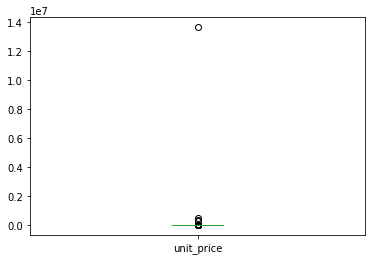

In [105]:
#Plot unit prices of items labelled with item_id = 319
(u_order[u_order.item_id == 319].unit_price).plot(kind='box')
plt.show()

In [106]:
#Compute median unit price
median_unit_price = u_order[u_order.item_id == 319].unit_price.median()

In [107]:
#Fill missing values
u_order.loc[(u_order.unit_price.isnull())&(u_order.item_id == 319) , 'unit_price'] = median_unit_price

In [108]:
#Check again for missing values
u_order[profile_features_ord].isnull().sum()

delivery_order_id    0
item_id              5
item_type            6
quantity             0
unit_price           5
dtype: int64

I leave the rest of the null values as is for now. 

## Menu

In [109]:
#Import data
menu = pd.read_csv('../raw/meals.csv')

In [110]:
# #Inspect data
# menu.sample()

In [111]:
#Define original dataset shape
initial_nrows = menu.shape[0]
initial_cols = menu.shape[1]

#Print number of unique menu items and features
print('Meals data includes information of {} unique menu items.'.format(menu.id.nunique())+'\n'+'\n'+'-'*75)
print('\n'+'There are {} features including:'.format(initial_cols))

list(menu.columns)

Meals data includes information of 607 unique menu items.

---------------------------------------------------------------------------

There are 26 features including:


['id',
 'name',
 'date',
 'price',
 'description',
 'created_at',
 'updated_at',
 'recipe_id',
 'serving',
 'meal_id',
 'sold_out',
 'macros',
 'drink',
 'restocking',
 'ingredients',
 'daily',
 'sides',
 'temperature',
 'category',
 'byline',
 'price_excluding_gst',
 'price_including_gst',
 'feedback_score',
 'is_archived',
 'is_resale',
 'premium_surcharge_per_pax']

<b> I keep only rows with `id` matching `item_id` in order info dataset because this means we can match this to order details. <b>

In [112]:
u_menu = menu[menu.id.isin(u_order.item_id)]

In [113]:
print('We only need information on {} unique menu items.'.format(u_menu.id.nunique()))

We only need information on 363 unique menu items.


Out of 607 menu items, only half were being ordered by users.

### Missing data

In [114]:
#Check for missing values
print('Columns with missing data are sorted starting from the column with most missing values:')

#Find % of missing values in each column
missing_pct = pd.DataFrame(u_menu.isnull().sum()/u_menu.shape[0], columns=['%Null']).sort_values('%Null',ascending=False)

#Print only those with missing values
missing_pct[missing_pct['%Null']> 0]

Columns with missing data are sorted starting from the column with most missing values:


,%Null
premium_surcharge_per_pax,1.000000
restocking,0.986226
sold_out,0.983471
date,0.977961
feedback_score,0.977961
daily,0.575758
drink,0.567493
serving,0.567493
byline,0.388430
temperature,0.063361


### Useful Features

Taking into consideration the amount of missing values in some columns, I identify the following columns to be useful for profiling users and prioritise data cleaning accordingly:


`macros`, `ingredients`, `temperature`, `category`

In [115]:
#Identify useful features
profile_features_men = ['id','name','macros','ingredients','temperature','category']

In [116]:
#Check for missing values
u_menu[profile_features_men].isnull().sum()

id              0
name            0
macros          3
ingredients     6
temperature    23
category        1
dtype: int64

For `macros`, I compute missing values as 0.

In [117]:
#Compute missing values as 0
u_menu.macros.fillna(0, inplace=True)

For null values in `temperature` I check what are the items and if we can logically fill the missing values. 

In [118]:
#Check possible values
u_menu.temperature.unique()

array([nan, 'warm', 'chilled', 'room'], dtype=object)

I inspect the names and descriptions of items with missing values for temperature a assign a value.

In [119]:
# #Inspect name of items with missing values for temperature
# u_menu[u_menu.temperature.isnull()].name.value_counts()

In [120]:
# #Loop through each unique item and print description for context
# lst = list(u_menu[u_menu.temperature.isnull()].name.unique())

# for i in lst:
#     print('{}: {} '.format(i,u_menu[u_menu.name == i].description.iloc[0])+'\n'+'-'*10)


In [121]:
#Fill in temperature using description context
censored

## Combined Dataset

I merge the dataframes on the respective keys, taking only the useful features identified. 

In [122]:
#Merge user data with delivery information using id, user_id respectively
users_delivery_info = users[profile_features].merge(
    delivery_info[profile_features_del], 
    left_on='id', 
    right_on='user_id', 
    suffixes=('_users', '_delivery_info')
)

In [123]:
#Check features
users_delivery_info.columns

Index(['id_users', 'account_balance', 'card_brand_users', 'has_coupon',
       'birthday_year', 'birthday_month', 'age', 'id_delivery_info', 'user_id',
       'address', 'zone_id', 'salesperson_id', 'discount', 'due_dates_only',
       'card_details', 'card_brand_delivery_info', 'source', 'delivery_fee',
       'meal_wave', 'surcharge_amount', 'promo_code_used', 'gave_feedback',
       'district'],
      dtype='object')

In [124]:
#Drop duplicate column
users_delivery_info.drop('id_users', axis=1, inplace=True)

In [125]:
#Check shape
users_delivery_info.shape

(32845, 22)

In [126]:
#Merge again using delivery data id, and delivery_order_id from Order data
users_delivery_info_order = users_delivery_info.merge(
    u_order[profile_features_ord], 
    left_on='id_delivery_info', 
    right_on='delivery_order_id',
    suffixes=('_users_delivery_info','orders')
)

In [127]:
#Check features
users_delivery_info_order.columns

Index(['account_balance', 'card_brand_users', 'has_coupon', 'birthday_year',
       'birthday_month', 'age', 'id_delivery_info', 'user_id', 'address',
       'zone_id', 'salesperson_id', 'discount', 'due_dates_only',
       'card_details', 'card_brand_delivery_info', 'source', 'delivery_fee',
       'meal_wave', 'surcharge_amount', 'promo_code_used', 'gave_feedback',
       'district', 'delivery_order_id', 'item_id', 'item_type', 'quantity',
       'unit_price'],
      dtype='object')

In [128]:
#Drop duplicate column
users_delivery_info_order.drop('id_delivery_info', axis=1, inplace=True)

In [129]:
#Check shape
users_delivery_info_order.shape

(57499, 26)

In [130]:
#Final merge matching item id to id in meals/menu data 
users_delivery_info_order_menu = users_delivery_info_order.merge(
    u_menu[profile_features_men],
    left_on='item_id', 
    right_on='id',
    how = 'left',
    suffixes=('_delivery_info','_menu')
)

In [131]:
#Check features
users_delivery_info_order_menu.columns

Index(['account_balance', 'card_brand_users', 'has_coupon', 'birthday_year',
       'birthday_month', 'age', 'user_id', 'address', 'zone_id',
       'salesperson_id', 'discount', 'due_dates_only', 'card_details',
       'card_brand_delivery_info', 'source', 'delivery_fee', 'meal_wave',
       'surcharge_amount', 'promo_code_used', 'gave_feedback', 'district',
       'delivery_order_id', 'item_id', 'item_type', 'quantity', 'unit_price',
       'id', 'name', 'macros', 'ingredients', 'temperature', 'category'],
      dtype='object')

In [132]:
#Drop duplicate column
users_delivery_info_order_menu.drop('id', axis=1, inplace=True)

In [133]:
#Check shape
users_delivery_info_order_menu.shape

(57499, 31)

In [134]:
#Output clean data
users_delivery_info_order_menu.to_csv('../inputs/profile_features_clean.csv',index=False)